In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime, timedelta
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact

import gensim.corpora as corpora
import gensim

# Granger test between GTrends views and tweets
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

In [131]:
list_of_lists = [['This is the first sentence.'], ['Here is another sentence.'], ['And one more.']]

# Flatten the list of lists and join the sentences into a single string with spaces between sentences
single_sentence = ' '.join([sentence for sublist in list_of_lists for sentence in sublist])

print(single_sentence)

This is the first sentence.Here is another sentence.And one more.


In [116]:
# build a personalyze data parser
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)

C:\Users\dandr_wh38grr\AppData\Local\Temp\ipykernel_24076\2600807054.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)


In [117]:
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

spacy_stopwords = list(spacy_stopwords)

In [118]:
df_clean = df.copy()

df_clean['text'] = df_clean['text'].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',x))

df_clean['text'] = df_clean['text'].apply(lambda x: x.lower())

for punctuation in [',', '.', ':', ';', '?', '!', '"', '/', '|', "'"]:
    df_clean['text'] = df_clean['text'].apply(lambda x: x.replace(punctuation, ' '))

for word in ['@realdonaldtrump', 'realdonaldtrump', 'rt', '&amp','trump', 'thank', 'people', 'great', 's']:

    df_clean['text'] = df_clean['text'].apply(lambda x: x.replace(' '+word+' ', ' '))

df_clean['text'] = df_clean['text'].apply(lambda x: x.replace('rt ', ''))
df_clean['text'] = df_clean['text'].apply(lambda x: x.replace('thank', ''))
df_clean['text'] = df_clean['text'].apply(lambda x: x.replace('president', ''))

In [119]:
df_march_april = df_clean[(df_clean['date']>'2020-03-01')&(df_clean['date']<'2020-05-31')]

In [120]:
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))

def remove_stopwords(texts, spacy_stopwords):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in spacy_stopwords] for doc in texts]

In [121]:
from gensim.utils import simple_preprocess

data = df_clean['text'].values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words, spacy_stopwords)

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


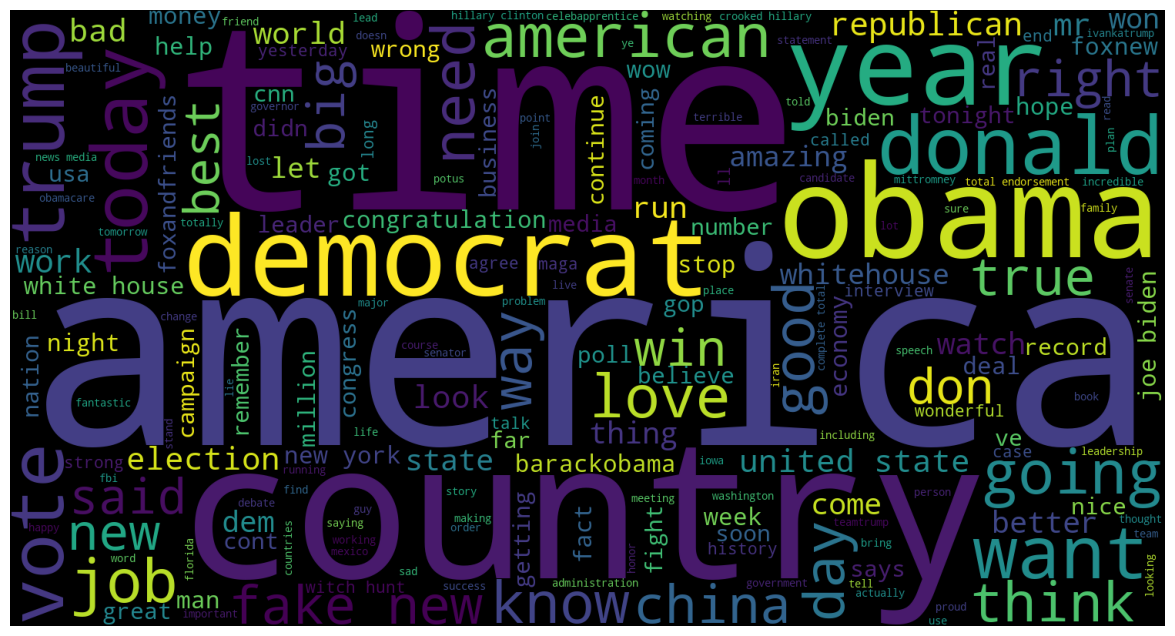

In [122]:
clean = ' '.join([sentence for sublist in data_words for sentence in sublist])

wordcloud = WordCloud(width=1500, height=800, random_state=21).generate(clean)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [123]:
data = df_march_april['text'].values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words, spacy_stopwords)

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


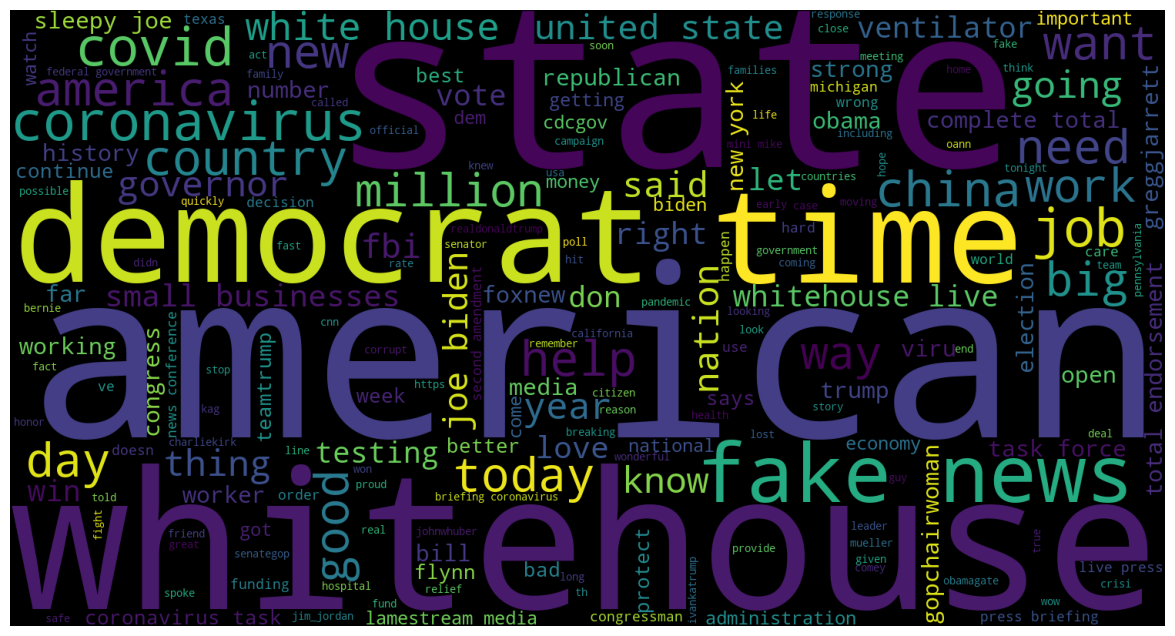

In [124]:
clean = ' '.join([sentence for sublist in data_words for sentence in sublist])

wordcloud = WordCloud(width=1500, height=800, random_state=21).generate(clean)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [125]:
id2word = corpora.Dictionary(data_words)

texts = data_words

corpus = [id2word.doc2bow(text) for text in texts]

In [126]:
from pprint import pprint

num_topics = 4

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"coronavirus" + 0.008*"news" + 0.006*"fake" + 0.006*"whitehouse" + '
  '0.006*"joe" + 0.005*"media" + 0.005*"biden" + 0.004*"country" + '
  '0.004*"house" + 0.004*"press"'),
 (1,
  '0.008*"coronavirus" + 0.007*"news" + 0.005*"covid" + 0.004*"new" + '
  '0.004*"today" + 0.004*"american" + 0.004*"whitehouse" + 0.003*"states" + '
  '0.003*"fake" + 0.003*"country"'),
 (2,
  '0.006*"coronavirus" + 0.006*"new" + 0.005*"whitehouse" + 0.005*"american" + '
  '0.004*"small" + 0.004*"businesses" + 0.004*"joe" + 0.004*"today" + '
  '0.004*"strong" + 0.004*"need"'),
 (3,
  '0.006*"news" + 0.005*"whitehouse" + 0.004*"job" + 0.004*"fake" + '
  '0.004*"states" + 0.003*"american" + 0.003*"world" + 0.003*"help" + '
  '0.003*"new" + 0.003*"country"')]


In [127]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import gensim

vis_data = gensimvis.prepare(lda_model, corpus, id2word)

pyLDAvis.display(vis_data)

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.col

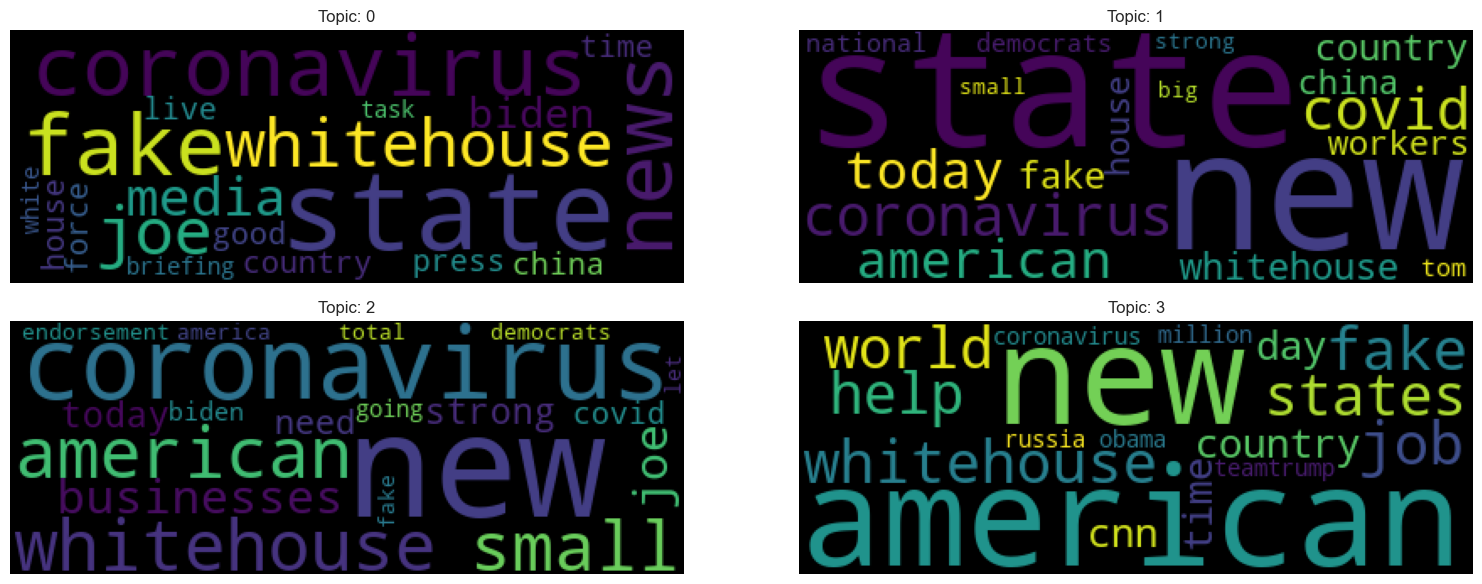

In [128]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming you have num_topics defined earlier and lda_model initialized

fig, axs = plt.subplots(1, 3, figsize=(16, 6))  # Creating a 2x2 subplot

for topic_id, topic in enumerate(lda_model.print_topics(num_topics=num_topics, num_words=20)):
    topic_words = " ".join([word.split("*")[1].strip() for word in topic[1].split(" + ")])
    wordcloud = WordCloud(width=400, height=150, random_state=21).generate(topic_words)

    # Determining subplot position
    row = topic_id // 2  # Row index (0 or 1)
    col = topic_id % 2   # Column index (0 or 1)

    axs[row, col].imshow(wordcloud)
    axs[row, col].axis("off")
    axs[row, col].set_title("Topic: {}".format(topic_id))

plt.tight_layout()
plt.show()
